**PHASE 3: MODELING - Determine Optimal K**

Purpose: Evaluate multiple k values to find optimal number of clusters  
Input: svd_reduced_{SVD_VARIANT}.pkl  
Output: k_evaluation_metrics_{SVD_VARIANT}.pkl, plots, recommendations  
Algorithm: MiniBatch K-Means with multiple k values  
ML Involved: ✓ YES - Unsupervised clustering with hyperparameter selection  
Runtime: ~60-90 minutes (depends on k range and dimensionality)  

Configuration: Set SVD_VARIANT at top of notebook
- "300d" for 53% variance path
- "500d" for 71% variance path

In [8]:
# configuration - set this for each path

SVD_VARIANT = "500d"  # Options: "300d" or "500d"

print(f"RUNNING K-SELECTION FOR SVD-{SVD_VARIANT.upper()}")

# imports
import pandas as pd
import numpy as np
import os
import sys
import joblib
import time
from datetime import datetime
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import matplotlib.pyplot as plt

# add project root to path
sys.path.append('..')
from config import CLUSTERING_K_RANGE, CLUSTERING_BATCH_SIZE, RANDOM_STATE

print("✓ All imports loaded")
print(f"\nConfiguration:")
print(f"  SVD variant: {SVD_VARIANT}")
print(f"  K range: {CLUSTERING_K_RANGE}")
print(f"  Batch size: {CLUSTERING_BATCH_SIZE}")
print(f"  Random state: {RANDOM_STATE}")

RUNNING K-SELECTION FOR SVD-500D
✓ All imports loaded

Configuration:
  SVD variant: 500d
  K range: [10, 15, 20, 25, 30, 35, 40, 45, 50]
  Batch size: 1024
  Random state: 42


In [9]:
# load SVD-reduced feature matrix

print(f"\nLoading SVD-reduced data for {SVD_VARIANT}...")
X_reduced = joblib.load(f'data/processed/svd_reduced_{SVD_VARIANT}.pkl')

print(f"✓ Loaded reduced matrix")
print(f"  Shape: {X_reduced.shape}")
print(f"  Papers: {X_reduced.shape[0]:,}")
print(f"  Features: {X_reduced.shape[1]}")
print(f"  Memory: {X_reduced.nbytes / 1024**3:.2f} GB")

# load paper IDs for alignment

df_ids = pd.read_pickle('data/processed/tfidf_paper_ids.pkl')
print(f"✓ Loaded paper IDs: {len(df_ids):,}")

# verify alignment

assert len(df_ids) == X_reduced.shape[0], "Mismatch between IDs and features!"
print("✓ ID-feature alignment verified")


Loading SVD-reduced data for 500d...
✓ Loaded reduced matrix
  Shape: (2384622, 500)
  Papers: 2,384,622
  Features: 500
  Memory: 4.44 GB
✓ Loaded paper IDs: 2,384,622
✓ ID-feature alignment verified


In [10]:
# initialize results storage for all k values

k_evaluation_results = []

print(f"\nWill evaluate {len(CLUSTERING_K_RANGE)} different k values")
print(f"K values: {CLUSTERING_K_RANGE}")
print(f"\nEstimated total time: {len(CLUSTERING_K_RANGE) * 6:.0f}-{len(CLUSTERING_K_RANGE) * 10:.0f} minutes")


Will evaluate 9 different k values
K values: [10, 15, 20, 25, 30, 35, 40, 45, 50]

Estimated total time: 54-90 minutes


In [11]:
# evaluate each k value

print("STARTING K-EVALUATION")

pipeline_start = time.time()

for i, k in enumerate(CLUSTERING_K_RANGE, 1):
    print(f"\n{'─'*60}")
    print(f"K = {k} ({i}/{len(CLUSTERING_K_RANGE)})")
    print(f"{'─'*60}")
    
    k_start_time = time.time()
    
    # initialize K-Means

    kmeans = MiniBatchKMeans(
        n_clusters=k,
        batch_size=CLUSTERING_BATCH_SIZE,
        random_state=RANDOM_STATE,
        max_iter=300,
        n_init=3,  # fewer inits for k-selection (faster)
        verbose=0
    )
    
    # fit and predict

    print(f"  Clustering with k={k}...")
    fit_start = time.time()
    labels = kmeans.fit_predict(X_reduced)
    fit_time = time.time() - fit_start
    print(f"  ✓ Clustering complete ({fit_time/60:.1f} minutes)")
    
    # calculate metrics

    print(f"  Calculating quality metrics...")
    metrics_start = time.time()
    
    # silhouette (sample for speed)

    sample_size = min(100000, X_reduced.shape[0])
    sample_indices = np.random.choice(X_reduced.shape[0], sample_size, replace=False)
    silhouette = silhouette_score(
        X_reduced[sample_indices],
        labels[sample_indices],
        sample_size=10000
    )
    
    # davies-Bouldin (full data - fast)
    davies_bouldin = davies_bouldin_score(X_reduced, labels)
    
    # calinski-Harabasz (full data - fast)
    calinski_harabasz = calinski_harabasz_score(X_reduced, labels)
    
    # inertia (from model)
    inertia = kmeans.inertia_
    
    metrics_time = time.time() - metrics_start
    
    # total time for this k
    k_total_time = time.time() - k_start_time
    
    # Store results
    result = {
        'k': k,
        'silhouette': silhouette,
        'davies_bouldin': davies_bouldin,
        'calinski_harabasz': calinski_harabasz,
        'inertia': inertia,
        'fit_time_seconds': fit_time,
        'metrics_time_seconds': metrics_time,
        'total_time_seconds': k_total_time,
        'n_samples': X_reduced.shape[0],
        'n_features': X_reduced.shape[1],
        'svd_variant': SVD_VARIANT,
        'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    }
    k_evaluation_results.append(result)
    
    # print results
    print(f"  ✓ Metrics calculated ({metrics_time:.1f} seconds)")
    print(f"\n  Results for k={k}:")
    print(f"    Silhouette:        {silhouette:>8.4f}")
    print(f"    Davies-Bouldin:    {davies_bouldin:>8.4f}")
    print(f"    Calinski-Harabasz: {calinski_harabasz:>8.1f}")
    print(f"    Inertia:           {inertia:>8.1f}")
    print(f"    Time:              {k_total_time/60:>8.1f} minutes")
    
    # progress update
    elapsed_total = (time.time() - pipeline_start) / 60
    remaining = len(CLUSTERING_K_RANGE) - i
    avg_time_per_k = elapsed_total / i
    eta = avg_time_per_k * remaining
    
    print(f"\n  Progress: {i}/{len(CLUSTERING_K_RANGE)} complete")
    print(f"  Elapsed: {elapsed_total:.1f} min | ETA: {eta:.1f} min")

pipeline_time = time.time() - pipeline_start

print("K-EVALUATION COMPLETE")
print(f"Total time: {pipeline_time/60:.1f} minutes")
print(f"Average per k: {pipeline_time/len(CLUSTERING_K_RANGE)/60:.1f} minutes")

STARTING K-EVALUATION

────────────────────────────────────────────────────────────
K = 10 (1/9)
────────────────────────────────────────────────────────────
  Clustering with k=10...
  ✓ Clustering complete (0.1 minutes)
  Calculating quality metrics...
  ✓ Metrics calculated (4.5 seconds)

  Results for k=10:
    Silhouette:          0.0043
    Davies-Bouldin:      6.0106
    Calinski-Harabasz:  13915.2
    Inertia:           1562631.1
    Time:                   0.1 minutes

  Progress: 1/9 complete
  Elapsed: 0.1 min | ETA: 1.1 min

────────────────────────────────────────────────────────────
K = 15 (2/9)
────────────────────────────────────────────────────────────
  Clustering with k=15...
  ✓ Clustering complete (0.0 minutes)
  Calculating quality metrics...
  ✓ Metrics calculated (4.5 seconds)

  Results for k=15:
    Silhouette:          0.0102
    Davies-Bouldin:      6.1266
    Calinski-Harabasz:  12080.6
    Inertia:           1535774.5
    Time:                   0.1 minute

In [12]:
# convert results to DataFrame for easier analysis

df_results = pd.DataFrame(k_evaluation_results)

print("\nK-Evaluation Results Summary:")
print(df_results[['k', 'silhouette', 'davies_bouldin', 'calinski_harabasz', 'inertia']].to_string(index=False))


K-Evaluation Results Summary:
 k  silhouette  davies_bouldin  calinski_harabasz     inertia
10    0.004316        6.010588       13915.176758 1562631.125
15    0.010173        6.126576       12080.616211 1535774.500
20    0.010105        5.200525       10361.073242 1519348.250
25    0.011501        4.848982        9623.184570 1500619.875
30    0.016398        4.911849        8470.045898 1491272.125
35    0.017748        4.497771        8214.591797 1474690.750
40    0.017059        4.396971        7610.174805 1466555.500
45    0.017303        3.997474        6841.585938 1471820.000
50    0.020635        4.122074        7084.287598 1437171.875


In [13]:
# find optimal k based on metrics

print("\nOptimal k by metric:")

# best silhouette (higher is better)
best_silhouette_k = df_results.loc[df_results['silhouette'].idxmax(), 'k']
best_silhouette_score = df_results['silhouette'].max()
print(f"Silhouette:        k={best_silhouette_k:>3} (score: {best_silhouette_score:.4f})")

# best davies-bouldin (lower is better)
best_db_k = df_results.loc[df_results['davies_bouldin'].idxmin(), 'k']
best_db_score = df_results['davies_bouldin'].min()
print(f"Davies-Bouldin:    k={best_db_k:>3} (score: {best_db_score:.4f})")

# best calinski-harabasz (higher is better)
best_ch_k = df_results.loc[df_results['calinski_harabasz'].idxmax(), 'k']
best_ch_score = df_results['calinski_harabasz'].max()
print(f"Calinski-Harabasz: k={best_ch_k:>3} (score: {best_ch_score:.1f})")

# elbow method (look for diminishing returns in inertia)
print(f"\nInertia reduction by k:")
for i in range(1, len(df_results)):
    prev_inertia = df_results.iloc[i-1]['inertia']
    curr_inertia = df_results.iloc[i]['inertia']
    reduction = (prev_inertia - curr_inertia) / prev_inertia * 100
    k_val = df_results.iloc[i]['k']
    print(f"  k={df_results.iloc[i-1]['k']:>2} → k={k_val:>2}: {reduction:>5.1f}% reduction")

print("-"*60)

# store recommendations
recommendations = {
    'best_silhouette_k': int(best_silhouette_k),
    'best_davies_bouldin_k': int(best_db_k),
    'best_calinski_harabasz_k': int(best_ch_k),
    'svd_variant': SVD_VARIANT
}


Optimal k by metric:
Silhouette:        k= 50 (score: 0.0206)
Davies-Bouldin:    k= 45 (score: 3.9975)
Calinski-Harabasz: k= 10 (score: 13915.2)

Inertia reduction by k:
  k=10 → k=15:   1.7% reduction
  k=15 → k=20:   1.1% reduction
  k=20 → k=25:   1.2% reduction
  k=25 → k=30:   0.6% reduction
  k=30 → k=35:   1.1% reduction
  k=35 → k=40:   0.6% reduction
  k=40 → k=45:  -0.4% reduction
  k=45 → k=50:   2.4% reduction
------------------------------------------------------------


In [14]:
# save evaluation results
metrics_path = f'data/processed/k_evaluation_metrics_{SVD_VARIANT}.pkl'
joblib.dump(k_evaluation_results, metrics_path)
print(f"✓ Saved evaluation metrics to: {metrics_path}")

# save recommendations
rec_path = f'data/processed/k_recommendations_{SVD_VARIANT}.pkl'
joblib.dump(recommendations, rec_path)
print(f"✓ Saved recommendations to: {rec_path}")

✓ Saved evaluation metrics to: data/processed/k_evaluation_metrics_500d.pkl
✓ Saved recommendations to: data/processed/k_recommendations_500d.pkl


---
## ⚠️ STOP HERE - CHANGE CONFIGURATION

**Just completed k-selection for:** `SVD_VARIANT = "{SVD_VARIANT}"`

**Before proceeding to comparison (Cell 9+):**

1. Change `SVD_VARIANT` in Cell 1 to the OTHER value
   - If you just ran "300d" → change to "500d"
   - If you just ran "500d" → change to "300d"

2. Restart kernel and run cells 1-8 again

3. Verify you have BOTH:
   - ✓ `k_evaluation_metrics_300d.pkl`
   - ✓ `k_evaluation_metrics_500d.pkl`

4. Then continue to Cell 9 below for comparison analysis

**DO NOT proceed until both variants are complete!**
---

In [15]:
# verify both 300d and 500d files exist before proceeding

required_files = [
    'data/processed/svd_reduced_300d.pkl',
    'data/processed/svd_reduced_500d.pkl',
    'data/processed/svd_variance_info_300.pkl',
    'data/processed/svd_variance_info_500.pkl'
]

missing = [f for f in required_files if not os.path.exists(f)]
if missing:
    print("x Error: Missing required files:")
    for f in missing:
        print(f"  - {f}")
    print("\nGo back and run cells 1-8 for missing configuration(s)")
    raise FileNotFoundError("Complete both SVD configurations first")
else:
    print("✓ Both SVD configurations found")

✓ Both SVD configurations found


In [16]:
# load results from both variants

print("\nLoading k-evaluation results for comparison...")

results_300d = joblib.load('data/processed/k_evaluation_metrics_300d.pkl')
results_500d = joblib.load('data/processed/k_evaluation_metrics_500d.pkl')

df_300d = pd.DataFrame(results_300d)
df_500d = pd.DataFrame(results_500d)

print(f"✓ Loaded 300d results: {len(df_300d)} k values")
print(f"✓ Loaded 500d results: {len(df_500d)} k values")

# load recommendations

rec_300d = joblib.load('data/processed/k_recommendations_300d.pkl')
rec_500d = joblib.load('data/processed/k_recommendations_500d.pkl')

print(f"\nRecommendations:")
print(f"  300d: Silhouette k={rec_300d['best_silhouette_k']}, DB k={rec_300d['best_davies_bouldin_k']}, CH k={rec_300d['best_calinski_harabasz_k']}")
print(f"  500d: Silhouette k={rec_500d['best_silhouette_k']}, DB k={rec_500d['best_davies_bouldin_k']}, CH k={rec_500d['best_calinski_harabasz_k']}")


Loading k-evaluation results for comparison...
✓ Loaded 300d results: 9 k values
✓ Loaded 500d results: 9 k values

Recommendations:
  300d: Silhouette k=50, DB k=50, CH k=10
  500d: Silhouette k=50, DB k=45, CH k=10


✓ Comparison plot saved to: results/figures/k_selection_comparison.png


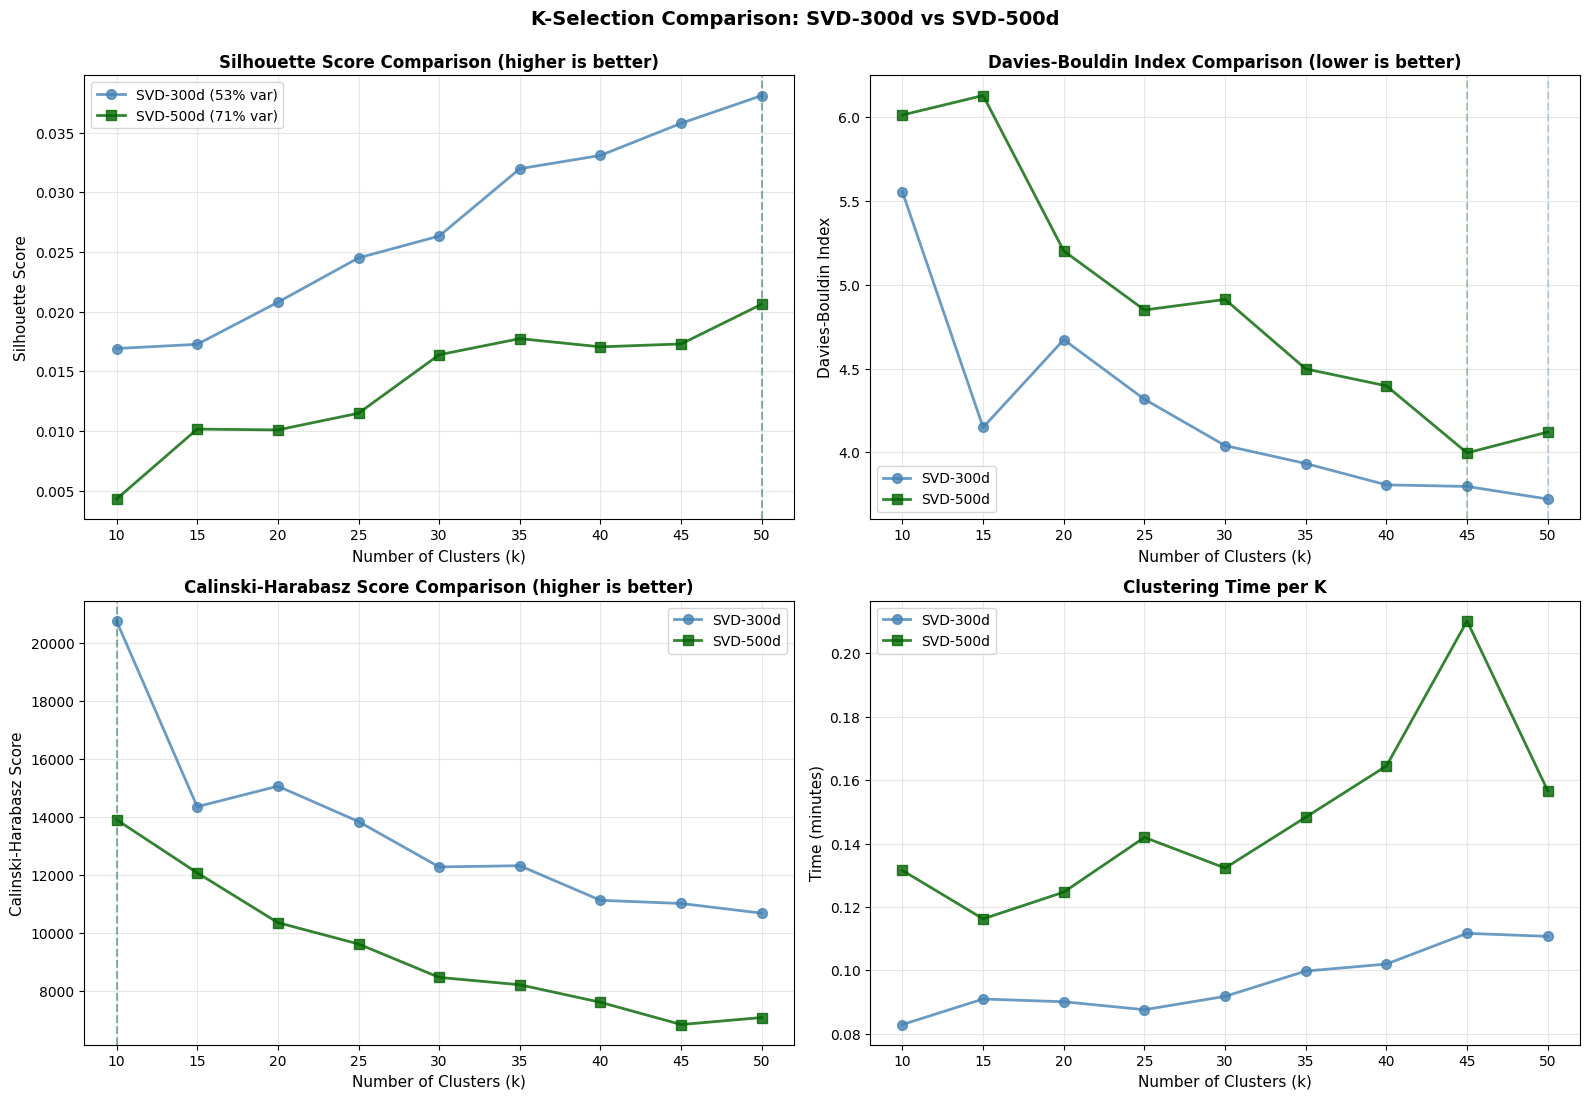

In [17]:
# create side-by-side comparison plot
fig, axes = plt.subplots(2, 2, figsize=(16, 11))

k_values = df_300d['k'].values  # should be same for both

# silhouette comparison
ax1 = axes[0, 0]
ax1.plot(k_values, df_300d['silhouette'], 'o-', linewidth=2, markersize=7, 
         color='steelblue', label='SVD-300d (53% var)', alpha=0.8)
ax1.plot(k_values, df_500d['silhouette'], 's-', linewidth=2, markersize=7, 
         color='darkgreen', label='SVD-500d (71% var)', alpha=0.8)
ax1.axvline(rec_300d['best_silhouette_k'], color='steelblue', linestyle='--', alpha=0.3)
ax1.axvline(rec_500d['best_silhouette_k'], color='darkgreen', linestyle='--', alpha=0.3)
ax1.set_xlabel('Number of Clusters (k)', fontsize=11)
ax1.set_ylabel('Silhouette Score', fontsize=11)
ax1.set_title('Silhouette Score Comparison (higher is better)', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend()

# davies-bouldin comparison
ax2 = axes[0, 1]
ax2.plot(k_values, df_300d['davies_bouldin'], 'o-', linewidth=2, markersize=7, 
         color='steelblue', label='SVD-300d', alpha=0.8)
ax2.plot(k_values, df_500d['davies_bouldin'], 's-', linewidth=2, markersize=7, 
         color='darkgreen', label='SVD-500d', alpha=0.8)
ax2.axvline(rec_300d['best_davies_bouldin_k'], color='steelblue', linestyle='--', alpha=0.3)
ax2.axvline(rec_500d['best_davies_bouldin_k'], color='darkgreen', linestyle='--', alpha=0.3)
ax2.set_xlabel('Number of Clusters (k)', fontsize=11)
ax2.set_ylabel('Davies-Bouldin Index', fontsize=11)
ax2.set_title('Davies-Bouldin Index Comparison (lower is better)', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend()

# calinski-harabasz comparison
ax3 = axes[1, 0]
ax3.plot(k_values, df_300d['calinski_harabasz'], 'o-', linewidth=2, markersize=7, 
         color='steelblue', label='SVD-300d', alpha=0.8)
ax3.plot(k_values, df_500d['calinski_harabasz'], 's-', linewidth=2, markersize=7, 
         color='darkgreen', label='SVD-500d', alpha=0.8)
ax3.axvline(rec_300d['best_calinski_harabasz_k'], color='steelblue', linestyle='--', alpha=0.3)
ax3.axvline(rec_500d['best_calinski_harabasz_k'], color='darkgreen', linestyle='--', alpha=0.3)
ax3.set_xlabel('Number of Clusters (k)', fontsize=11)
ax3.set_ylabel('Calinski-Harabasz Score', fontsize=11)
ax3.set_title('Calinski-Harabasz Score Comparison (higher is better)', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3)
ax3.legend()

# runtime comparison
ax4 = axes[1, 1]
ax4.plot(k_values, df_300d['total_time_seconds']/60, 'o-', linewidth=2, markersize=7, 
         color='steelblue', label='SVD-300d', alpha=0.8)
ax4.plot(k_values, df_500d['total_time_seconds']/60, 's-', linewidth=2, markersize=7, 
         color='darkgreen', label='SVD-500d', alpha=0.8)
ax4.set_xlabel('Number of Clusters (k)', fontsize=11)
ax4.set_ylabel('Time (minutes)', fontsize=11)
ax4.set_title('Clustering Time per K', fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3)
ax4.legend()

plt.suptitle('K-Selection Comparison: SVD-300d vs SVD-500d', 
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()

# save comparison plot
plot_path = 'results/figures/k_selection_comparison.png'
plt.savefig(plot_path, dpi=150, bbox_inches='tight')
print(f"✓ Comparison plot saved to: {plot_path}")

plt.show()

In [18]:
# save comparison summary readable text file

comparison_path = 'results/k_selection_comparison.txt'

with open(comparison_path, 'w') as f:
    f.write("K-SELECTION COMPARISON: SVD-300D VS SVD-500D\n")
    f.write(f"Analysis date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")
    
    f.write("CONFIGURATION COMPARISON\n")
    f.write(f"{'Metric':<25} {'SVD-300d':<25} {'SVD-500d'}\n")
    f.write(f"{'Variance preserved':<25} {'53%':<25} {'71%'}\n")
    f.write(f"{'Feature dimensions':<25} {str(df_300d.iloc[0]['n_features']):<25} {str(df_500d.iloc[0]['n_features'])}\n")
    f.write(f"{'Compression ratio':<25} {'3.3x':<25} {'2.0x'}\n")
    f.write(f"{'Papers clustered':<25} {df_300d.iloc[0]['n_samples']:>9,}{' '*15} {df_500d.iloc[0]['n_samples']:>9,}\n")
    
    f.write(f"\n")
    f.write("OPTIMAL K BY METRIC\n")
    f.write(f"{'Metric':<25} {'SVD-300d':<25} {'SVD-500d'}\n")
    f.write(f"{'Silhouette':<25} k={rec_300d['best_silhouette_k']:<23} k={rec_500d['best_silhouette_k']}\n")
    f.write(f"{'Davies-Bouldin':<25} k={rec_300d['best_davies_bouldin_k']:<23} k={rec_500d['best_davies_bouldin_k']}\n")
    f.write(f"{'Calinski-Harabasz':<25} k={rec_300d['best_calinski_harabasz_k']:<23} k={rec_500d['best_calinski_harabasz_k']}\n")
    
    f.write(f"\n")
    f.write("QUALITY METRICS AT RECOMMENDED K VALUES\n")
    
    # For each recommended k from 300d
    for metric_name, k_val in [('Silhouette', rec_300d['best_silhouette_k']),
                                 ('Davies-Bouldin', rec_300d['best_davies_bouldin_k']),
                                 ('Calinski-Harabasz', rec_300d['best_calinski_harabasz_k'])]:
        f.write(f"\n{metric_name} optimal k={k_val}:\n")
        
        # Get scores for this k from both variants
        row_300d = df_300d[df_300d['k'] == k_val].iloc[0]
        row_500d = df_500d[df_500d['k'] == k_val].iloc[0]
        
        f.write(f"  SVD-300d: Sil={row_300d['silhouette']:.4f}, DB={row_300d['davies_bouldin']:.4f}, CH={row_300d['calinski_harabasz']:.1f}\n")
        f.write(f"  SVD-500d: Sil={row_500d['silhouette']:.4f}, DB={row_500d['davies_bouldin']:.4f}, CH={row_500d['calinski_harabasz']:.1f}\n")
    
    f.write(f"\n")
    f.write("RUNTIME COMPARISON\n")
    
    total_300d = df_300d['total_time_seconds'].sum() / 60
    total_500d = df_500d['total_time_seconds'].sum() / 60
    avg_300d = df_300d['total_time_seconds'].mean() / 60
    avg_500d = df_500d['total_time_seconds'].mean() / 60
    
    f.write(f"Total k-selection time:\n")
    f.write(f"  SVD-300d: {total_300d:.1f} minutes\n")
    f.write(f"  SVD-500d: {total_500d:.1f} minutes\n")
    f.write(f"  Difference: {total_500d - total_300d:.1f} minutes ({(total_500d/total_300d - 1)*100:+.1f}%)\n\n")
    
    f.write(f"Average time per k:\n")
    f.write(f"  SVD-300d: {avg_300d:.1f} minutes\n")
    f.write(f"  SVD-500d: {avg_500d:.1f} minutes\n")
    f.write(f"  Difference: {avg_500d - avg_300d:.1f} minutes ({(avg_500d/avg_300d - 1)*100:+.1f}%)\n")
    
    f.write(f"\n")
    f.write("DETAILED RESULTS TABLE\n")
    f.write(f"{'K':<5} {'300d Sil':<12} {'500d Sil':<12} {'300d DB':<12} {'500d DB':<12} {'300d CH':<15} {'500d CH'}\n")
    
    for _, row_300d in df_300d.iterrows():
        k_val = int(row_300d['k'])
        row_500d = df_500d[df_500d['k'] == k_val].iloc[0]
        
        f.write(f"{k_val:<5} "
                f"{row_300d['silhouette']:<12.4f} "
                f"{row_500d['silhouette']:<12.4f} "
                f"{row_300d['davies_bouldin']:<12.4f} "
                f"{row_500d['davies_bouldin']:<12.4f} "
                f"{row_300d['calinski_harabasz']:<15.1f} "
                f"{row_500d['calinski_harabasz']:.1f}\n")

print(f"✓ Saved comparison summary to: {comparison_path}")

✓ Saved comparison summary to: results/k_selection_comparison.txt


In [ ]:
# verify all outputs (individual + comparison)

print("\nVerifying all outputs...")

# individual files from both variants

individual_files = [
    'data/processed/k_evaluation_metrics_300d.pkl',
    'data/processed/k_evaluation_metrics_500d.pkl',
    'data/processed/k_recommendations_300d.pkl',
    'data/processed/k_recommendations_500d.pkl',
]

# comparison files

comparison_files = [
    'results/k_selection_comparison.txt',
    'results/figures/k_selection_comparison.png'
]

all_files = individual_files + comparison_files

print("\nIndividual variant files:")
for filepath in individual_files:
    if os.path.exists(filepath):
        print(f"✓ {filepath}")
    else:
        print(f"x Missing: {filepath}")

print("\nComparison files:")
for filepath in comparison_files:
    if os.path.exists(filepath):
        print(f"✓ {filepath}")
    else:
        print(f"x Missing: {filepath}")

all_good = all(os.path.exists(f) for f in all_files)

if all_good:
    print("\n Success! - All files created!")
    print(f"\nK-selection complete for BOTH SVD variants")
    print(f"\nRecommended k values:")
    print(f"  SVD-300d: k={rec_300d['best_silhouette_k']} (silhouette), k={rec_300d['best_davies_bouldin_k']} (DB), k={rec_300d['best_calinski_harabasz_k']} (CH)")
    print(f"  SVD-500d: k={rec_500d['best_silhouette_k']} (silhouette), k={rec_500d['best_davies_bouldin_k']} (DB), k={rec_500d['best_calinski_harabasz_k']} (CH)")
else:
    print("\nx Error - Some files missing!")
    print("Check which variant needs to be rerun")


Verifying all outputs...

Individual variant files:
------------------------------------------------------------
✓ data/processed/k_evaluation_metrics_300d.pkl
✓ data/processed/k_evaluation_metrics_500d.pkl
✓ data/processed/k_recommendations_300d.pkl
✓ data/processed/k_recommendations_500d.pkl
x Missing: results/k_selection_summary_300d.txt
x Missing: results/k_selection_summary_500d.txt
x Missing: results/figures/k_selection_metrics_300d.png
x Missing: results/figures/k_selection_metrics_500d.png

Comparison files:
------------------------------------------------------------
✓ results/k_selection_comparison.txt
✓ results/figures/k_selection_comparison.png

x Error - Some files missing!
Check which variant needs to be rerun
